In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd /content/drive/MyDrive/Colab Notebooks/Predict Accident Risk (Swiss Comp)/Modelling/PoissonGAM

/content/drive/MyDrive/Colab Notebooks/Predict Accident Risk (Swiss Comp)/modelling/PoissonGAM


In [ ]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 4.1 MB/s 


In [ ]:
# Load Necessary Libraries

import os
import pandas as pd
import numpy as np
from datetime import datetime
import copy

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

from pygam import PoissonGAM, s, f
from sklearn.metrics import mean_squared_error

seed = 5

# Load and Prepare Saved Data

In [ ]:
# Get parent directory (One level up)
path_parent = os.path.dirname(os.getcwd())
# Join path name as parent directory and file name
path_file_train = os.path.join(path_parent, 'accident_train.csv')
path_file_test = os.path.join(path_parent, 'accident_test.csv')

In [ ]:
## Load preprocessed file

Xy_train = pd.read_csv(path_file_train, sep = ',')
Xy_test = pd.read_csv(path_file_test, sep = ',')

## Stratified Shuffle Split

In [ ]:
features = df.drop(columns = ['Number_of_Casualties']).columns

In [ ]:
strat_shuf_split = StratifiedShuffleSplit(n_splits = 1, 
                                          test_size = 0.3, 
                                          random_state = seed)

train_idx, test_idx = next(strat_shuf_split.split(df[features], df.Number_of_Casualties))

# Create the dataframes
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, 'Number_of_Casualties']

X_test  = df.loc[test_idx, features]
y_test  = df.loc[test_idx, 'Number_of_Casualties']

len(X_train), len(X_test)

(335118, 143623)

In [ ]:
# Joining explanatory and outcome data to make it easier for us to perform EDA

Xy_train = pd.concat([X_train, y_train], axis = 1)
Xy_test = pd.concat([X_test, y_test], axis = 1)

In [ ]:
Xy_train.head(2)

,Accident_ID,Police_Force,Number_of_Vehicles,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,...,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country,Number_of_Casualties
441609,553509,13,1,20/03/12,2,22:55,198,E10000002,6,4,...,Fine without high winds,Dry,None,None,1,Yes,England,HR4 9QT,United Kingdom,1
208513,261144,33,1,01/01/12,3,12:08,295,E10000029,5,6,...,Fine without high winds,Dry,None,None,2,Yes,England,NE46 4BB,United Kingdom,1


In [ ]:
# Resetting index after shuffle split 

Xy_train = Xy_train.reset_index(drop = True)
Xy_test = Xy_test.reset_index(drop = True)

# Feature Engineering
#### Creating New Features and Removing Unnecessary Columns

In [ ]:
def remove_columns(data, col):
  data = copy.deepcopy(data)
  return data.drop(columns = col)

In [ ]:
highway_grouped_train = Xy_train['Local_Authority_(Highway)'].str.split('', n = 2, expand = True)
highway_grouped_test = Xy_test['Local_Authority_(Highway)'].str.split('', n = 2, expand = True)

In [ ]:
Xy_train['LA_Highway_Grouped'] = highway_grouped_train[1]
Xy_test['LA_Highway_Grouped'] = highway_grouped_test[1]

In [ ]:
Xy_train = remove_columns(Xy_train, ['country', '2nd_Road_Number', 
                                     'Local_Authority_(District)', 'Local_Authority_(Highway)',
                                     '1st_Road_Number'])
Xy_test = remove_columns(Xy_test, ['country', '2nd_Road_Number', 
                                   'Local_Authority_(District)', 'Local_Authority_(Highway)',
                                   '1st_Road_Number'])

# Treating Missing Values

In [ ]:
def fill_missing(data, column):
  data = copy.deepcopy(data)  
  data[column] = data[column].fillna('missing')
  return data

In [ ]:
# Fill missing value

Xy_train = fill_missing(Xy_train, ['Road_Surface_Conditions', 'Special_Conditions_at_Site'])
Xy_test = fill_missing(Xy_test, ['Road_Surface_Conditions', 'Special_Conditions_at_Site'])

In [ ]:
# Fill missing time

Xy_train['Time'] = Xy_train['Time'].fillna("13:50")
Xy_test['Time'] = Xy_test['Time'].fillna("13:50")

# Feature Engineering

After filling missing value for time, we can continue with extraction of new features from 'Date' and 'Time' as discussed earlier

### New Feature - Month, Part_of_Day

In [ ]:
def join_date_time(data):
  data = copy.deepcopy(data)
  data['Date_Time'] = pd.to_datetime(data['Date'] + data['Time'], 
                                     format='%d/%m/%y%H:%M', errors = 'ignore')
  data = data.drop(columns = ['Date', 'Time'])
  return data

In [ ]:
def prepare_date_time(data):

  data = join_date_time(data)

  # binning time as per part of the day
  hour_min = (data['Date_Time'] - pd.Timedelta(hours = 5)).dt.hour
  hour_cat = pd.cut(include_lowest = True, x = hour_min, 
                    right = False, bins = [0, 7, 12, 16, 24],
                    labels = ['Morning', 'Noon', 'Evening', 'Night'])
  data['Part_of_Day'] = hour_cat.cat.codes

  # extracting new month columns
  month = data.Date_Time.dt.month.values
  data['Month'] = month.reshape(-1,1)

  data = data.drop(columns = ['Date_Time'])  
  return data

In [ ]:
Xy_train = prepare_date_time(Xy_train)
Xy_test = prepare_date_time(Xy_test)

# Encoding

We know our input and output categorical data needs to be encoded to numeric type, before we can feed it to our model.
We need to choose the right type of encoding for our categorical data to represent it in the correct way.

### Cyclical Encoding

'Part of the Day', 'Day of the Week' and 'Month' ,all follow a circular pattern and we shall use cyclical encoding for them to best represent them

Note:
* We can also use modified one hot encoding - weighed smoothing method to represent where '0' and '1' will represent as usual presence and absence of the category type and also use an additional '0.5' value right before and after '1' to show relation with each other. e.g - wednesday can be shown as [0 0.5 1 0.5 0 0 0] where we begin the list from 'Monday'  

In [ ]:
def cyclical_enc(data): 
    data = copy.deepcopy(data)  
    data['Part_of_Day_Sin'] = (np.sin((data.Part_of_Day) * (2 * np.pi/4))).astype('float16')
    data['Part_of_Day_Cos'] = (np.cos((data.Part_of_Day) * (2 * np.pi/4))).astype('float16')
    data['Day_of_Week_Sin'] = (np.sin((data.Day_of_Week) * (2 * np.pi/7))).astype('float16')
    data['Day_of_Week_Cos'] = (np.cos((data.Day_of_Week) * (2 * np.pi/7))).astype('float16')
    data['Month_Sin'] = (np.sin((data.Month) * (2 * np.pi/12))).astype('float16')
    data['Month_Cos'] = (np.cos((data.Month) * (2 * np.pi/12))).astype('float16')
    
    data = data.drop(columns = ['Day_of_Week', 'Part_of_Day', 'Month'])
    return data

In [ ]:
Xy_train = cyclical_enc(Xy_train)
Xy_test = cyclical_enc(Xy_test)

### Prepare Data for Modelling

We will model our data such that we will first predict 'Number_of_Casualties' by using Poisson GAM (Columns 'Accident_ID'and 'postcode' removed during training) and after training, calculate 'Accident Risk Index' using the calculated predicted values, 'Accident Id' and 'postcode'.

Note: We can also model for 'Accident Risk Index' and predict its value directly. However, for that that data needs to be stratified split across 'postcode' as well and all 'postcode' type which contain a unit/single data point/value need to be either upsampled or manually added to training data set (Stratified Split won't work for datasets with unit value counts/frequency)

In [ ]:
def prepare_model_data(data, output_col, remove_col):
  X = data.drop(columns = output_col + remove_col)
  y = data['Number_of_Casualties']
  y = y.values.ravel()
  return X, y

In [ ]:
X_train, y_train = prepare_model_data(Xy_train, ['Number_of_Casualties'], 
                                      ['Accident_ID', 'postcode'])
X_test, y_test = prepare_model_data(Xy_test, ['Number_of_Casualties'], 
                                      ['Accident_ID', 'postcode'])

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(335118, 23) (335118,)
(143623, 23) (143623,)


We will next define a function to prepare the data so as to calculate 'Accident Risk Index'

In [ ]:
def cal_ari(data):
  # we need to calculate Accident_Risk_Index as sum(Number_of_casualities)/count(Accident_ID)
  grouped_train = data.groupby('postcode') # group by postcode
  
  #create aggregation functions
  aggregations = {'Number_of_Casualties': [np.mean],
                  'Accident_ID': [np.count_nonzero]}
  aggregated_ = grouped_train.agg(aggregations)
  
  # formula mentioned above is used to calculate <Accident_Risk_Index>
  aggregated_['Accident_risk_index'] = aggregated_['Number_of_Casualties']['mean']/aggregated_['Accident_ID']['count_nonzero']
  return aggregated_

Preparing Test Data with 'Accident Risk Index'

In [ ]:
ari_test = cal_ari(Xy_test)

# Metric

We will use mean squared error metric to measure performance of our models


# Training

We will demonstrate now how to use Poisson GAM algorithm for training and building our model

### Baseline Possion GAM 

Baseline Poisson GAM will be built using mean encoding.

* Note: For variables with high cardinality, it is recommended to use mean/target encoding. For variables with low cardinality it is recommended to use one hot encoding as they will help in inferencing our model.

Later we will build a model with mean encoded and one hot encoded variables as they will be better for inference.




In [ ]:
from pygam import PoissonGAM, s, f

In [ ]:
model_pgam = PoissonGAM(terms = 'auto')

In [ ]:
pgam = model_pgam.fit(X_train, y_train)

In [ ]:
pgam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     96.3515
Link Function:                          LogLink Log Likelihood:                                -436062.597
Number of Samples:                       335118 AIC:                                           872317.8969
                                                AICc:                                          872317.9541
                                                UBRE:                                               2.3598
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0175
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


# Training Plots

In [ ]:
def pgam_plot(model, data):
    pgam_col = data.columns
    for i, term in enumerate(model.terms):
      if term.isintercept:
        continue
      
      XX = model.generate_X_grid(term = i)
      pdep, confi = model.partial_dependence(term = i, X = XX, width = 0.95)

      plt.figure()
      plt.plot(XX[:, term.feature], pdep)
      plt.plot(XX[:, term.feature], confi, c = 'r', ls = '--')
      plt.title("{} - {}".format(repr(term), pgam_col[i]))
      plt.show()

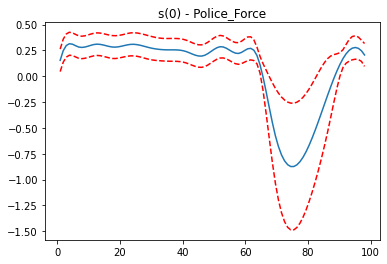

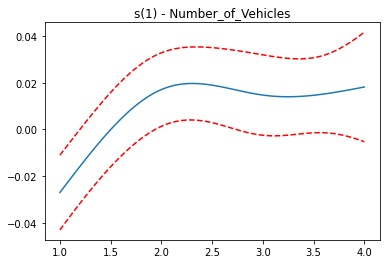

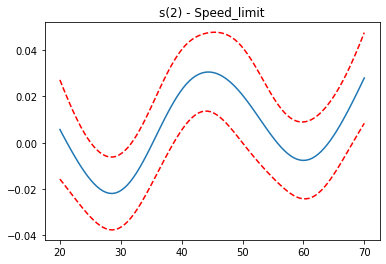

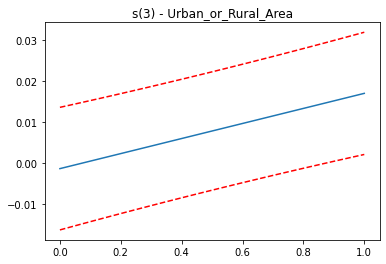

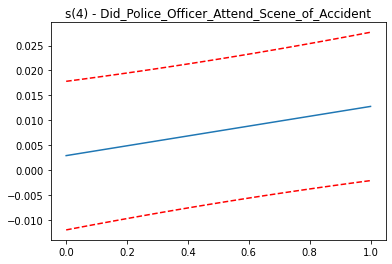

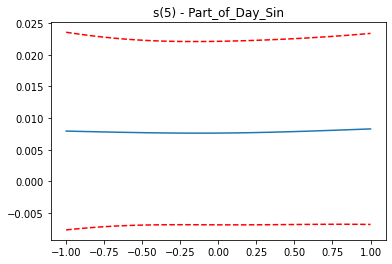

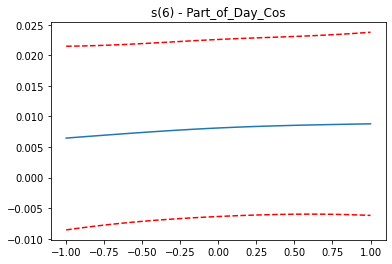

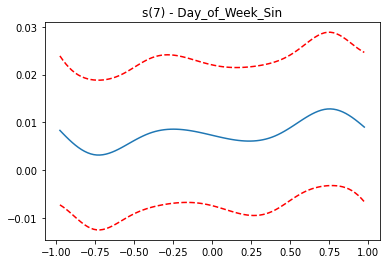

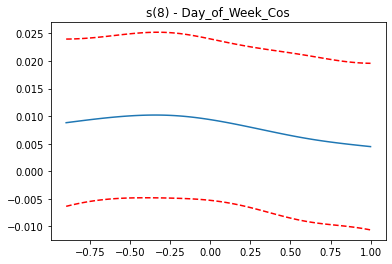

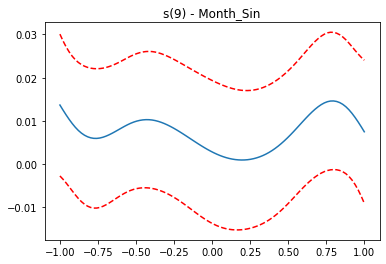

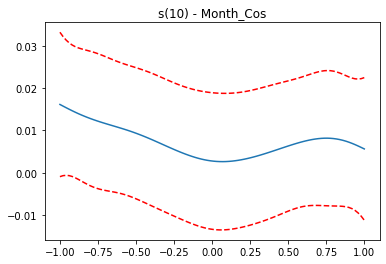

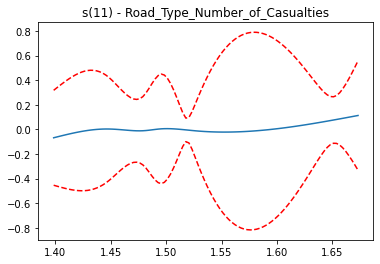

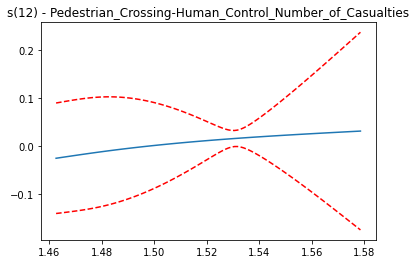

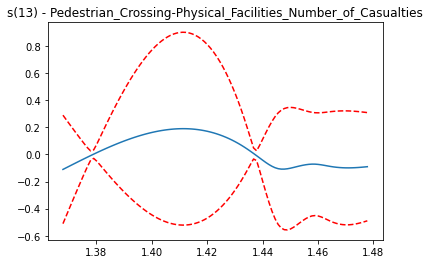

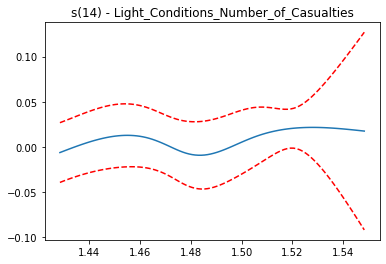

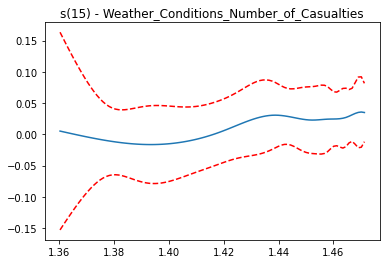

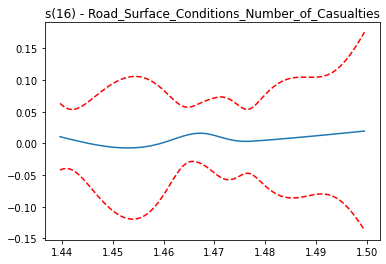

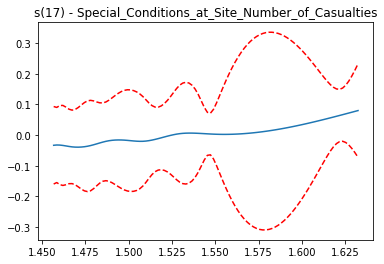

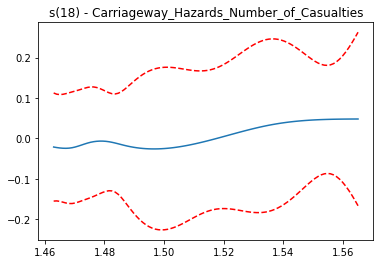

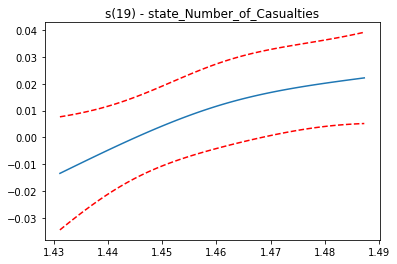

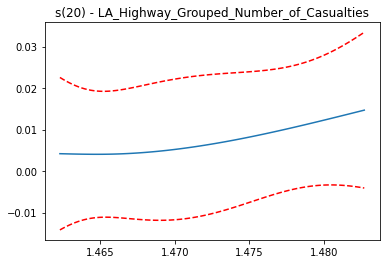

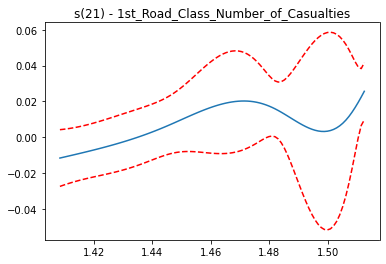

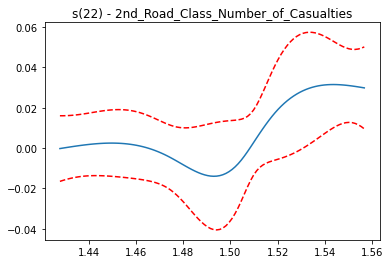

In [ ]:
pgam_plot(pgam, X_train)


# Evaluation

### Evaluation Plots

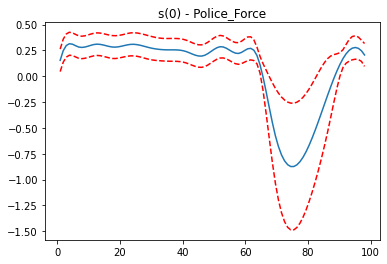

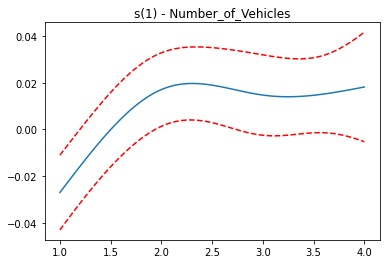

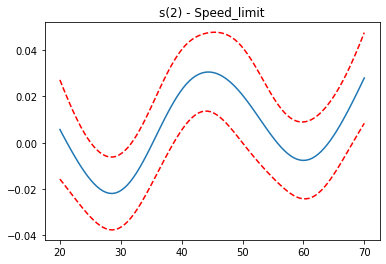

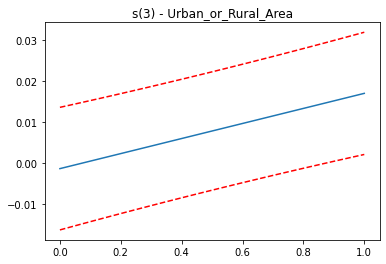

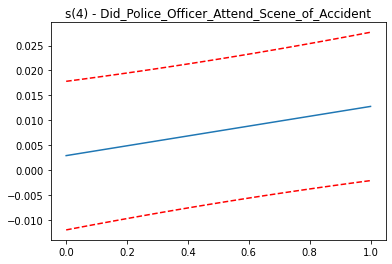

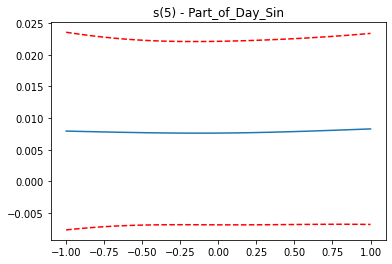

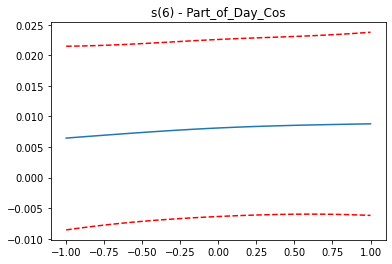

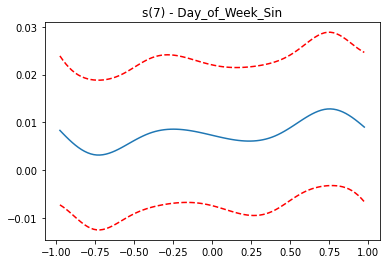

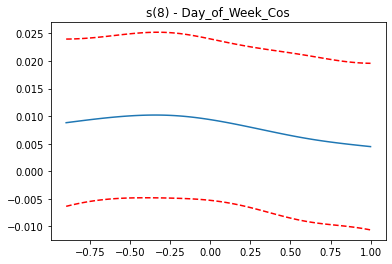

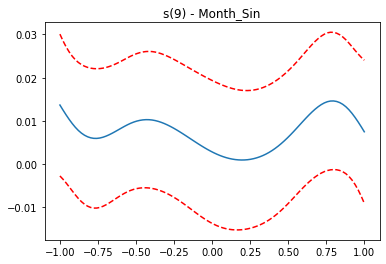

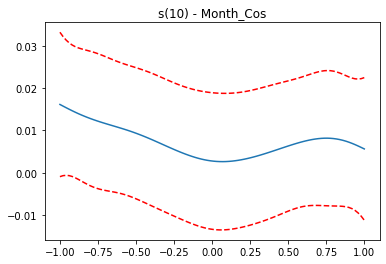

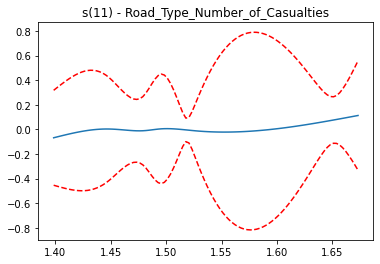

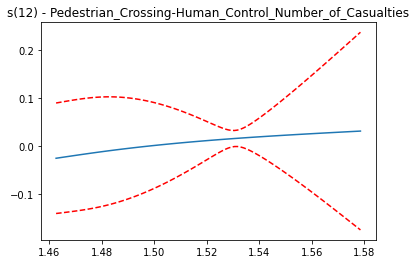

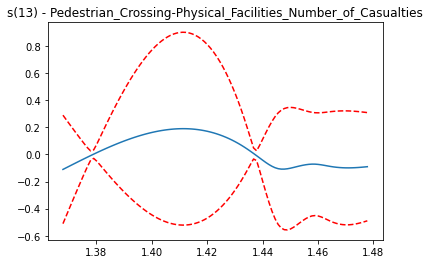

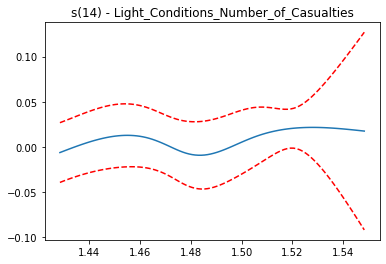

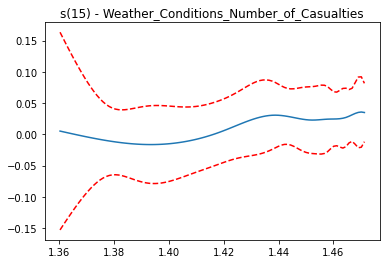

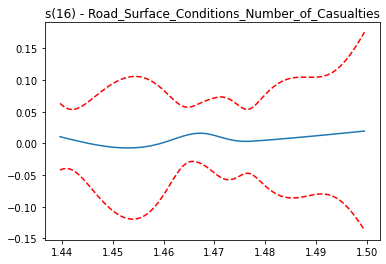

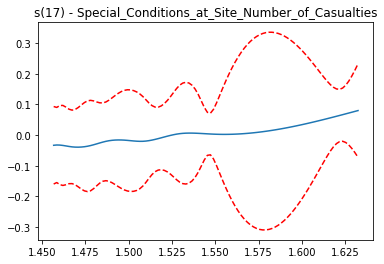

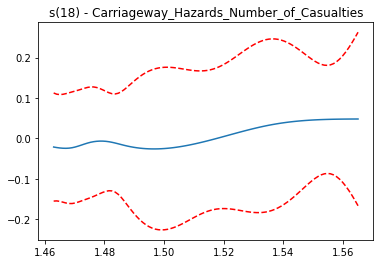

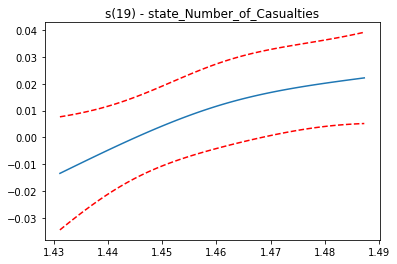

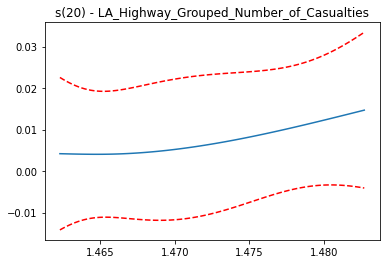

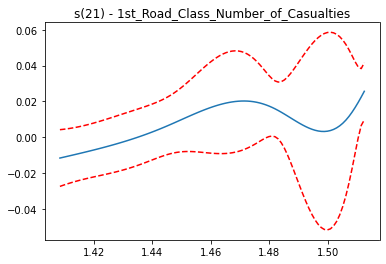

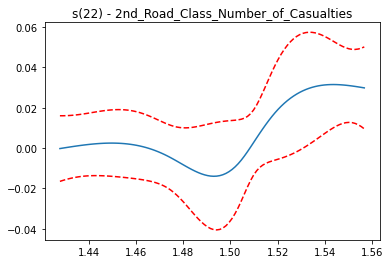

In [ ]:
pgam_plot(pgam, X_test)

In [ ]:
model_predict = pgam.predict(X_test)

Mean Squared Error for 'Number of Casualties'

In [ ]:
print("Mean Squared Error: {}".format(mean_squared_error(y_test, model_predict,  squared = False)))

Mean Squared Error: 0.8103829291665109


Calculating Accident Risk Index for predicted values

In [ ]:
pred_test = copy.deepcopy(Xy_test)

pred_test['Number_of_Casualties'] = model_predict

In [ ]:
ari_pred = cal_ari(pred_test)

Mean Squared Error for 'Accident Risk Index'

In [ ]:
print("Mean Squared Error: {}".format(mean_squared_error(ari_test['Accident_risk_index'], 
                                                         ari_pred['Accident_risk_index'],
                                                         squared = False)))

Mean Squared Error: 0.5465540138007944


We observe our baseline Poisson GAM performance is as good as our best Gradient Boosted Model by H2O.
GAM models have the added advantage of providing inference.

## Simpler(Reduced) Poisson GAM

Poisson GAM using 7 most important features from SHAP summary plots (H2O)

In [ ]:
X_train_imp = X_train[['Police_Force', 'Number_of_Vehicles', '1st_Road_Class_Number_of_Casualties', 
                       'Speed_limit', 'Urban_or_Rural_Area', '2nd_Road_Class_Number_of_Casualties',
                       'Light_Conditions_Number_of_Casualties']]
X_test_imp = X_test[['Police_Force', 'Number_of_Vehicles', '1st_Road_Class_Number_of_Casualties', 
                     'Speed_limit', 'Urban_or_Rural_Area', '2nd_Road_Class_Number_of_Casualties',
                     'Light_Conditions_Number_of_Casualties']]

* 's' refers to spline terms
* 'f' refers to factors/ categorical terms
* 'l' refers to linear term
* 'te' refers to tensor term

* Note:  Due to bug in pygam library, we need categorical variables i.e. factor('f') terms to be in the form of 0,1 or 0,1,2 etc and not other int values. So, we will encode them first before we can build our model

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
X_train_enc = copy.deepcopy(X_train_imp)
X_test_enc = copy.deepcopy(X_test_imp)

In [ ]:
ord = OrdinalEncoder()

X_train_enc['Light_Conditions_Number_of_Casualties'] \
                        = ord.fit_transform(X_train_imp[['Light_Conditions_Number_of_Casualties']])

In [ ]:
X_test_enc['Light_Conditions_Number_of_Casualties'] \
                        = ord.fit_transform(X_test_imp[['Light_Conditions_Number_of_Casualties']])

In [ ]:
model_pgam = PoissonGAM(terms = s(0) + s(1, n_splines = 25) + s(2) \
                        + s(3) + f(4) + s(5) + f(6))

In [ ]:
pgam = model_pgam.fit(X_train_enc, y_train)

In [ ]:
pgam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     37.7954
Link Function:                          LogLink Log Likelihood:                               -436102.3289
Number of Samples:                       335118 AIC:                                           872280.2484
                                                AICc:                                          872280.2576
                                                UBRE:                                               2.3595
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0168
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


### Training Plot

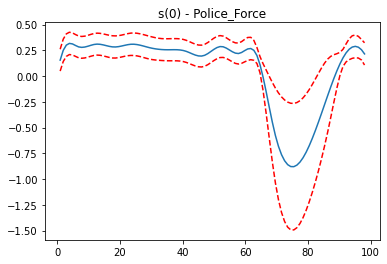

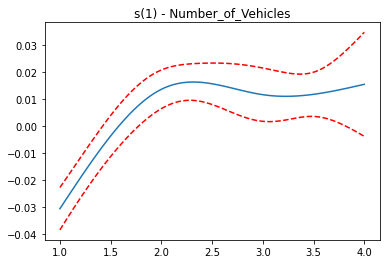

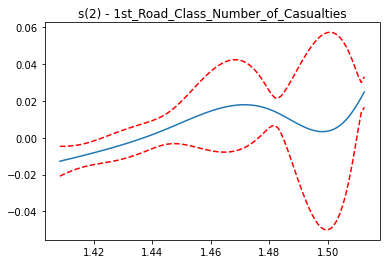

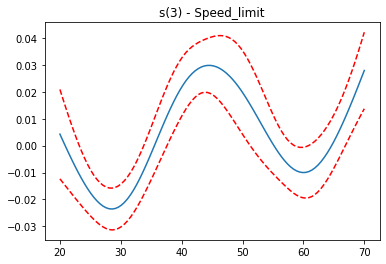

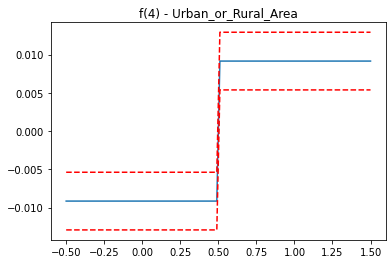

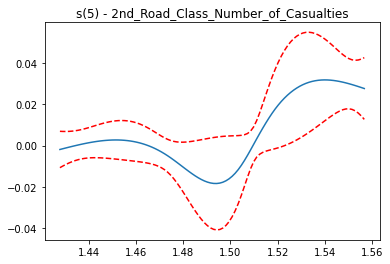

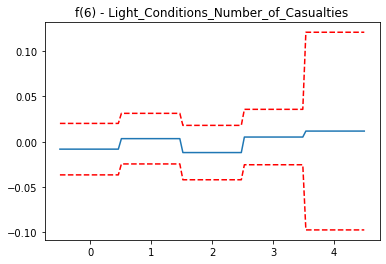

In [ ]:
pgam_plot(pgam, X_train_enc)

### Evaluation Plots

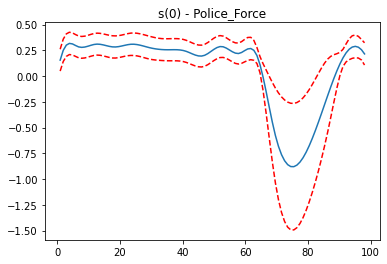

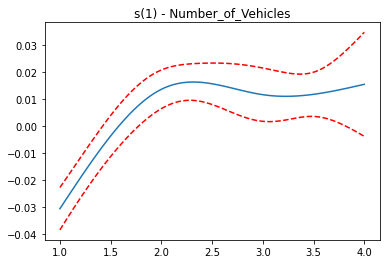

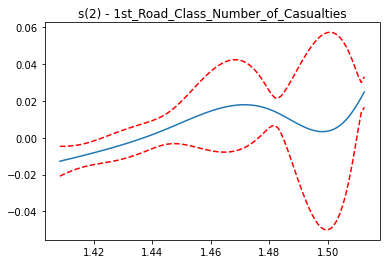

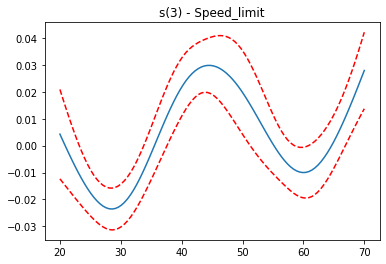

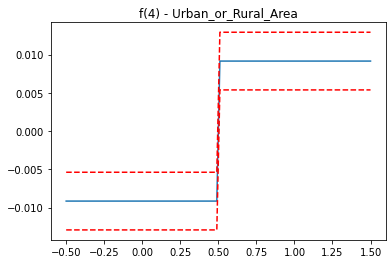

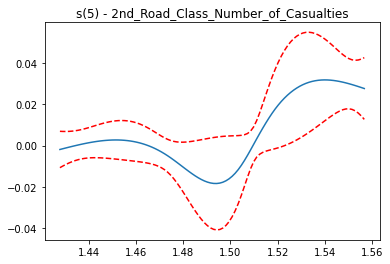

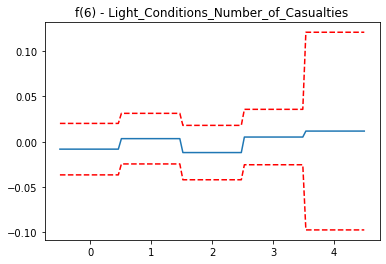

In [ ]:
pgam_plot(pgam, X_test_enc)

### Prediction

In [ ]:
model_predict = pgam.predict(X_test_enc)

Mean Squared Error for 'Number of Casualties'

In [ ]:
print("Mean Squared Error: {}".format(mean_squared_error(y_test, model_predict,  squared = False)))

Mean Squared Error: 0.8104649017472693


Calculating Accident Risk Index for predicted values

In [ ]:
pred_test = copy.deepcopy(Xy_test)

pred_test['Number_of_Casualties'] = model_predict

In [ ]:
ari_pred = cal_ari(pred_test)

Mean Squared Error for 'Accident Risk Index'

In [ ]:
print("Mean Squared Error: {}".format(mean_squared_error(ari_test['Accident_risk_index'], 
                                                         ari_pred['Accident_risk_index'],
                                                         squared = False)))

Mean Squared Error: 0.5465114176911805


We observe that our performance is still the same even with reduced features.

## Poisson GAM Grid Search

Here, we will show how to select hyperparameters with Grid Search for Poisson GAM 

In [ ]:
# hyperparameters for 7 terms

lam = np.logspace(-1, 1, 2)
lams = [lam, lam, 0.6, 0.6, 0.6, 0.5, 0.5]

Note: For setting grid lambda for all terms:- 
lams = [lam] * 5 

For using 'Grid search' we need to first fit our model and only afterwards can use it. 

In [ ]:
# Setting grid for first 2 terms only 
model_pgam = PoissonGAM(terms = s(0) + s(1) + s(2) + s(3) + f(4) \
                        + s(5) + f(6), n_splines = 50)

In [ ]:
pgam = model_pgam.fit(X_train_enc, y_train)

In [ ]:
pgam.gridsearch(X_train_enc, y_train, lam = lams)

100% (4 of 4) |##########################| Elapsed Time: 0:02:37 Time:  0:02:37


PoissonGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + f(4) + s(5) + f(6) + intercept, 
   tol=0.0001, verbose=False)

In [ ]:
pgam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     50.7064
Link Function:                          LogLink Log Likelihood:                               -436079.9918
Number of Samples:                       335118 AIC:                                           872261.3965
                                                AICc:                                          872261.4128
                                                UBRE:                                               2.3595
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0172
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


### Training Plot

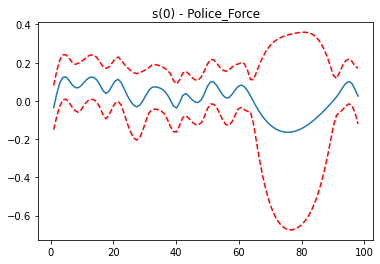

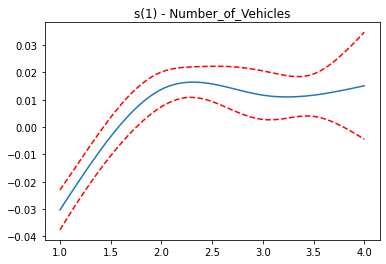

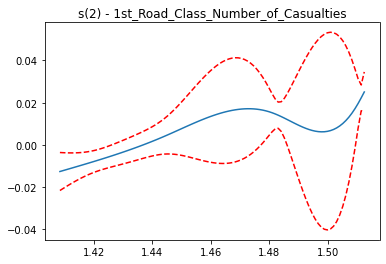

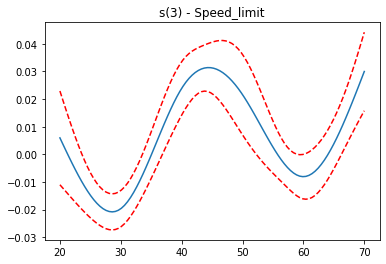

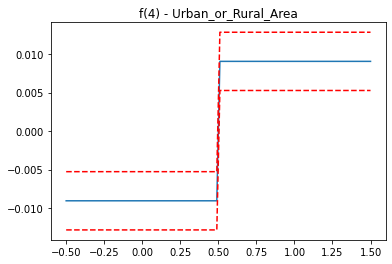

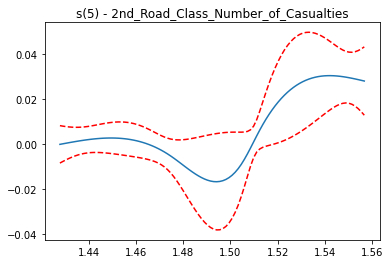

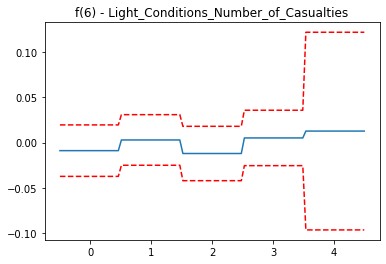

In [ ]:
pgam_plot(pgam, X_train_enc)

### Evaluation Plots

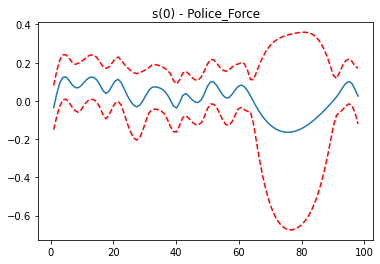

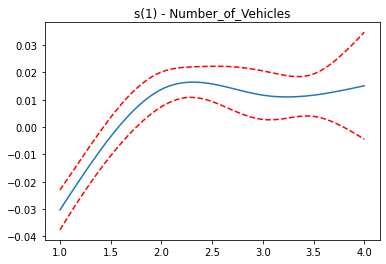

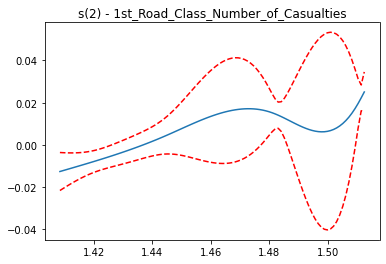

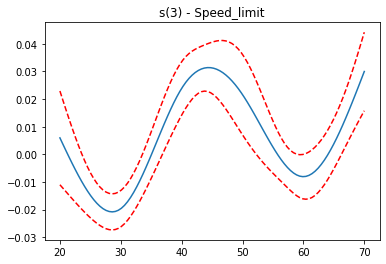

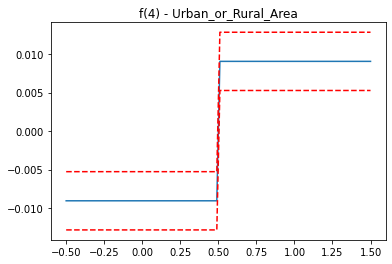

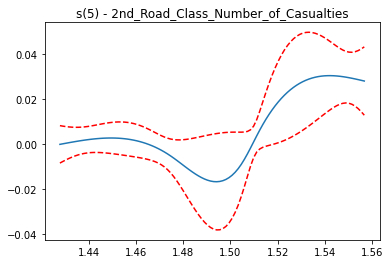

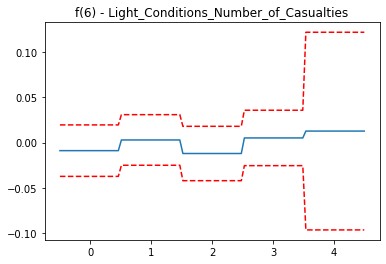

In [ ]:
pgam_plot(pgam, X_test_enc)

### Prediction

In [ ]:
model_predict = pgam.predict(X_test_enc)

Mean Squared Error for 'Number of Casualties'

In [ ]:
print("Mean Squared Error: {}".format(mean_squared_error(y_test, model_predict,  squared = False)))

Mean Squared Error: 0.8102803749788707


Calculating Accident Risk Index for predicted values

In [ ]:
pred_test = copy.deepcopy(Xy_test)

pred_test['Number_of_Casualties'] = model_predict

In [ ]:
ari_pred = cal_ari(pred_test)

Mean Squared Error for 'Accident Risk Index'

In [ ]:
print("Mean Squared Error: {}".format(mean_squared_error(ari_test['Accident_risk_index'], 
                                                         ari_pred['Accident_risk_index'],
                                                         squared = False)))

Mean Squared Error: 0.5463725386658083
